# Part 1: The Invariant Mass Distribution

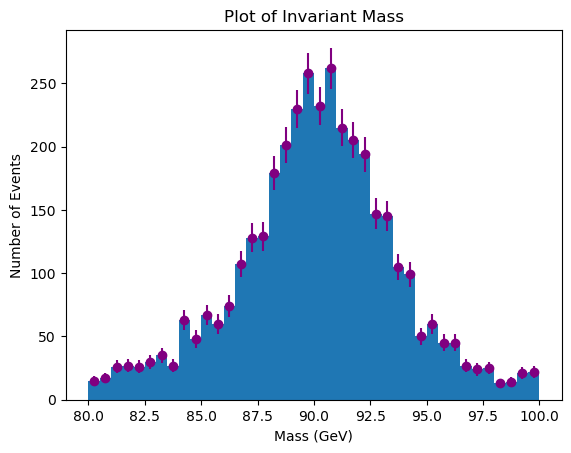

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.optimize import curve_fit

# Load the atlas dataset
atlas_data = np.loadtxt("atlas_z_to_ll.csv", delimiter = ',', skiprows = 1)

# Set up an array of zeros and fill with calculated mass
mass_invar = np.zeros(5000)

for i in range(len(mass_invar)):
    # Assign values to calculate p1
    E1 = atlas_data[i][6]
    pt1 = atlas_data[i][0]
    pseudo1 = atlas_data[i][2]
    azimuth1 = atlas_data[i][4]

    # Assign values to calculate p2
    E2 = atlas_data[i][7]
    pt2 = atlas_data[i][1]
    pseudo2 = atlas_data[i][3]
    azimuth2 = atlas_data[i][5] 

    # Calculate total momentum of system with two particles
    p_tot = (E1+E2, pt1*np.cos(azimuth1) + pt2*np.cos(azimuth2), pt1*np.sin(azimuth1) + pt2*np.sin(azimuth2), pt1*np.sinh(pseudo1) + pt2*np.sinh(pseudo2))

    # Calculate mass of hypothetical particle
    mass = np.sqrt(p_tot[0]**2 - (p_tot[1]**2 + p_tot[2]**2 + p_tot[3]**2))

    # Update the matrix of zeroes
    mass_invar[i] += mass

# Make a histogram with error bars for invariant mass
fig, ax1 = plt.subplots()
bins = np.linspace(80, 100, 41)

n, edges, extra = ax1.hist(mass_invar, bins = bins)
errors = np.sqrt(n)
centers = (edges[:-1]+edges[1:])/2

ax1.errorbar(centers, n, yerr=errors, fmt='o', color = 'purple')
ax1.set_xlabel('Mass (GeV)')
ax1.set_ylabel('Number of Events')
ax1.set_title('Plot of Invariant Mass');

# Part 2: Breit-Wigner Fit

Chi-Square: 9.985
Reduced Chi-Square: 0.999
P-Value: 0.442
The best fit mass m0 is 90.341 GeV, with uncertainty +/- 0.094


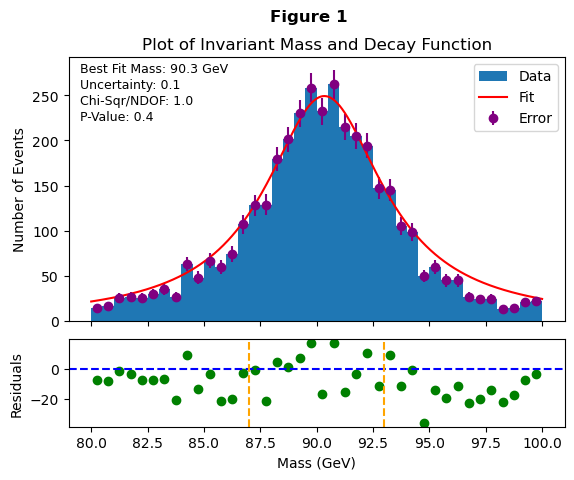

In [166]:
# Define decay function scaled by 2500 (= half the data points)
def decay(m, m0, L):
    return 2500 * (1/np.pi) * ((L/2)/((m-m0)**2 + (L/2)**2))

# Create mask for data to only fit within specified range
mask = (centers > 87) & (centers < 93)
mask_centers = centers[mask]
mask_n = n[mask]
mask_errors = errors[mask]

# Fit that thang (you know how it be)
params, covar = curve_fit(decay, mask_centers, mask_n, sigma = mask_errors, absolute_sigma = True)

# Plot decay function with fit parameters
mvals = np.linspace(80, 100, 1000)
decay_fit = decay(mvals, params[0], params[1])

fig, (ax_top, ax_bot) = plt.subplots(2, 1, sharex=True, gridspec_kw = {"height_ratios": [3,1], "hspace": 0.1})

ax_top.hist(mass_invar, bins = bins, label = 'Data')
ax_top.errorbar(centers, n, yerr = errors, fmt = 'o', color = 'purple', label = 'Error')
ax_top.plot(mvals, decay_fit, color = 'red', label = 'Fit')

ax_top.set_ylabel('Number of Events')
ax_top.set_title('Plot of Invariant Mass and Decay Function')
ax_top.legend();

# Plot the residuals
decay_extended = decay(centers, params[0], params[1])
residuals = n - decay_extended

ax_bot.plot(centers, residuals, 'go')
ax_bot.axhline(y = 0,  ls = '--', color = 'blue')
ax_bot.axvline(x = 87, ls = '--', color = 'orange')
ax_bot.axvline(x = 93, ls = '--', color = 'orange')
ax_bot.set_xlabel('Mass (GeV)')
ax_bot.set_ylabel('Residuals')

# Calculate chi-sq, reduced chi-sq, p-value within fitting range
decay_expected = decay(mask_centers, params[0], params[1])
DoF = len(mask_n) - len(params)

chisq = np.sum(((mask_n - decay_expected)/mask_errors)**2)
red_chisq = chisq/DoF
pvalue = st.chi2.sf(chisq, 10)

print("Chi-Square:", round(chisq,3))
print("Reduced Chi-Square:", round(red_chisq,3))
print("P-Value:", round(pvalue,3))

# Get best fit mass and its uncertainty
m0_best = params[0]
uncertainty = np.sqrt(covar[0][0])
print(f"The best fit mass m0 is {m0_best:.3f} GeV, with uncertainty +/- {uncertainty:.3f}")

# Update the plot
ax_top.text(79.5, 275, f'Best Fit Mass: {m0_best:.1f} GeV', fontsize = 9)
ax_top.text(79.5, 257.5, f'Uncertainty: {uncertainty:.1f}', fontsize = 9)
ax_top.text(79.5, 240, f'Chi-Sqr/NDOF: {red_chisq:.1f}', fontsize = 9)
ax_top.text(79.5, 222.5, f'P-Value: {pvalue:.1f}', fontsize = 9)
fig.suptitle('Figure 1', fontweight = 'bold');

# Part 3: 2D Parameter Contours

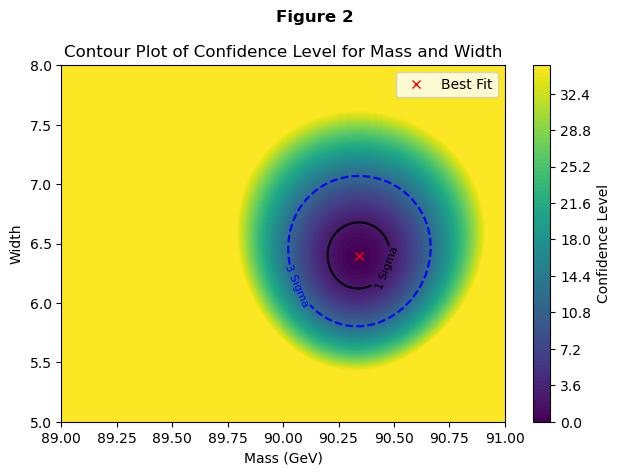

In [164]:
# Set up 2D chi-square grid
mass_scan = np.linspace(89, 91, 300)
width_scan = np.linspace(5, 8, 300)

chisq_grid = np.zeros((300, 300))
for i, m0 in enumerate(mass_scan):
    for j, L in enumerate(width_scan):
        expected = decay(mask_centers, m0, L)
        chi = np.sum(((mask_n - expected) / mask_errors)**2)
        chisq_grid[j,i] += chi

# Calculate difference between chi-square and minimum of chi-square
chisq_min = np.min(chisq_grid)
delta = chisq_grid - chisq_min

# Make filled contour plot
mass_vals, width_vals = np.meshgrid(mass_scan, width_scan)
delta_clip = np.clip(delta, 0, 35)

fig, ax_cont = plt.subplots()
contour = ax_cont.contourf(mass_vals, width_vals, delta_clip, levels = 100)
cbar = fig.colorbar(contour)
cbar.set_label("Confidence Level")

ax_cont.set_xlabel('Mass (GeV)')
ax_cont.set_ylabel('Width')

# Add confidence levels
contour_lines = ax_cont.contour(mass_vals, width_vals, delta_clip, levels = [2.3, 11.83], linestyles = ['solid', 'dashed'], colors = ['black', 'blue'])
ax_cont.clabel(contour_lines, inline = True, inline_spacing = .5, fmt = {2.30: '1 Sigma', 11.83: '3 Sigma'}, fontsize = 8)

# Plot best fit point
L_best = params[1]
ax_cont.plot(m0_best, L_best, 'rx', label = 'Best Fit')
ax_cont.set_title('Contour Plot of Confidence Level for Mass and Width')
ax_cont.legend()
fig.suptitle('Figure 2', fontweight = 'bold')
fig.tight_layout()